In [1]:
# https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
# https://colab.research.google.com/github/rpi-techfundamentals/website_spring_2020/blob/master/content/notebooks/20-deep-learning1/06-regression-bh-pytorch.ipynb#scrollTo=xD9PhAU7hoqT
#!pip install torchvision
import numpy as np
import pandas as pd
import pyreadr
import scipy
#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.autograd import Variable

In [2]:
# check pytorch version
import torch
print(torch.__version__)

1.4.0


In [44]:
class Net(torch.nn.Module):
    def __init__(self, cols, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(cols, size_hidden)   # hidden layer
        self.predict = torch.nn.Linear(size_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [45]:
def build_cnn(TrainSet_eonr2_df, policy, pred_vars):
    #Define training hyperprameters.
    batch_size = 50
    num_epochs = 200
    learning_rate = 0.01
    size_hidden= 100
    
    y_train = TrainSet_eonr2_df['eonr']
    #X_train = TrainSet_eonr2_df.drop('eonr', axis=1)
    X_train = TrainSet_eonr2_df[pred_vars]
    
    X_train=X_train.values
    y_train=y_train.values

    #Calculate some other hyperparameters based on data.  
    batch_no = len(X_train) // batch_size  #batches
    cols=X_train.shape[1] #Number of columns in input matrix
    n_output=1

    #Create the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Assume that we are on a CUDA machine, then this should print a CUDA device:
    print("Executing the model on :",device)

    net = Net(cols, size_hidden, n_output)

    #Adam is a specific flavor of gradient decent which is typically better
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
    criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss

    running_loss = 0.0
    for epoch in range(num_epochs):
        #Shuffle just mixes up the dataset between epocs
        X_train, y_train = shuffle(X_train, y_train)
        # Mini batch learning
        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            inputs = Variable(torch.FloatTensor(X_train[start:end]))
            labels = Variable(torch.FloatTensor(y_train[start:end]))
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print("outputs",outputs)
            #print("outputs",outputs,outputs.shape,"labels",labels, labels.shape)
            loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        #print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
        running_loss = 0.0
    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    torch.save(net.state_dict(), path)
    return(net)  
        

In [47]:
#Build one cnn using the function
pred_vars = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/pred_vars.rds")[None] # also works for RData
pred_vars = [item for sublist in pred_vars.values.tolist()  for item in sublist]

TrainSet_eonr2_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/TrainSet_eonr2.rds")[None] # also works for RData
net_return = build_cnn(TrainSet_eonr2_df, 'ratio_5', pred_vars)

Executing the model on : cuda:0


/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [50]:
#Make predictions with returned model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X_pred = prediction_set_aggregated_df[pred_vars]

X_pred=X_pred.values

X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net_return(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred
prediction_set_aggregated_df['eonr_pred'] = y_pred

# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
prediction_set_aggregated_df.head()

,id_10,id_field,region,z,eonr_12,rain_30,rain_60,rain_90,t_max_30,t_max_60,...,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm,area_ha,eonr_pred
0,5,1.0,3.0,11,200.0,125.0,229.0,17.0,22.050000,15.216667,...,0.408,243.606978,1.348166,662.246303,34.683799,452.674493,7.023629,27.525726,40.0,165.309891
1,5,1.0,3.0,13,210.0,140.0,108.0,19.0,22.133333,15.933333,...,0.402,243.606978,1.353492,695.201566,39.575462,510.279893,7.023629,27.525726,40.0,193.119644
2,5,1.0,3.0,15,280.0,96.0,101.0,39.0,20.666667,16.783333,...,0.406,243.606978,1.349796,651.399385,43.670958,483.728258,7.023629,27.525726,40.0,183.759811
3,5,1.0,3.0,17,190.0,96.0,47.0,33.0,22.016667,17.066667,...,0.397,243.606978,1.347865,660.076690,60.248224,461.893101,7.023629,27.525726,40.0,218.047867
4,5,1.0,3.0,19,200.0,43.0,183.0,51.0,23.916667,12.283333,...,0.398,243.606978,1.351097,655.163924,52.186478,717.156611,7.023629,27.525726,40.0,190.555481


In [51]:
#Load the saved model
policy = 'ratio_5'
path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
net_load = Net(21, 100, 1)
net_load.load_state_dict(torch.load(path))
net_load.eval()
net_load.state_dict()


OrderedDict([('hidden.weight',
              tensor([[ 0.1372, -0.1971, -0.0606,  ..., -0.2512, -0.2691,  0.0628],
                      [-0.0526,  0.1776,  0.1677,  ..., -0.1337,  0.1462, -0.1391],
                      [-0.0758, -0.2612,  0.0712,  ..., -0.0849,  0.1007, -0.2702],
                      ...,
                      [ 0.0983,  0.5921, -0.4065,  ..., -0.1831, -0.5872,  0.1895],
                      [-0.5648, -0.4506,  0.3021,  ..., -0.3076,  0.2977, -0.2526],
                      [ 0.0365,  0.2425, -0.4131,  ..., -0.0344, -0.5278,  0.1060]])),
             ('hidden.bias',
              tensor([ 7.7296e-02, -1.8275e-01,  3.4560e-02, -1.1699e-01, -3.1447e-02,
                       1.3137e-02,  3.5005e-01, -3.1334e-01, -2.6400e-01, -2.1809e-01,
                       1.9869e-01, -2.3288e-01, -1.6545e-01,  1.0722e-02,  7.9205e-02,
                       9.4230e-02, -1.7260e-01, -1.1624e-01,  1.2321e-02,  5.6737e-02,
                      -3.5287e-02,  1.2695e-03,  1.2579e+0

In [52]:
#Make predictions with the saved model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X_pred = prediction_set_aggregated_df[pred_vars]
X_pred=X_pred.values
X_pred
X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net_load(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred
prediction_set_aggregated_df['eonr_pred'] = y_pred

# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
prediction_set_aggregated_df.head()

,id_10,id_field,region,z,eonr_12,rain_30,rain_60,rain_90,t_max_30,t_max_60,...,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm,area_ha,eonr_pred
0,5,1.0,3.0,11,200.0,125.0,229.0,17.0,22.050000,15.216667,...,0.408,243.606978,1.348166,662.246303,34.683799,452.674493,7.023629,27.525726,40.0,165.309891
1,5,1.0,3.0,13,210.0,140.0,108.0,19.0,22.133333,15.933333,...,0.402,243.606978,1.353492,695.201566,39.575462,510.279893,7.023629,27.525726,40.0,193.119644
2,5,1.0,3.0,15,280.0,96.0,101.0,39.0,20.666667,16.783333,...,0.406,243.606978,1.349796,651.399385,43.670958,483.728258,7.023629,27.525726,40.0,183.759811
3,5,1.0,3.0,17,190.0,96.0,47.0,33.0,22.016667,17.066667,...,0.397,243.606978,1.347865,660.076690,60.248224,461.893101,7.023629,27.525726,40.0,218.047867
4,5,1.0,3.0,19,200.0,43.0,183.0,51.0,23.916667,12.283333,...,0.398,243.606978,1.351097,655.163924,52.186478,717.156611,7.023629,27.525726,40.0,190.555481


In [53]:
# Make a function that loads the saved model and does predictions

prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None]
prediction_set_aggregated_df.head()

,id_10,id_field,region,z,eonr_12,rain_30,rain_60,rain_90,t_max_30,t_max_60,...,day_v5,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm,area_ha
0,5,1.0,3.0,11,200.0,125.0,229.0,17.0,22.050000,15.216667,...,152.0,0.408,243.606978,1.348166,662.246303,34.683799,452.674493,7.023629,27.525726,40.0
1,5,1.0,3.0,13,210.0,140.0,108.0,19.0,22.133333,15.933333,...,147.0,0.402,243.606978,1.353492,695.201566,39.575462,510.279893,7.023629,27.525726,40.0
2,5,1.0,3.0,15,280.0,96.0,101.0,39.0,20.666667,16.783333,...,157.0,0.406,243.606978,1.349796,651.399385,43.670958,483.728258,7.023629,27.525726,40.0
3,5,1.0,3.0,17,190.0,96.0,47.0,33.0,22.016667,17.066667,...,157.0,0.397,243.606978,1.347865,660.076690,60.248224,461.893101,7.023629,27.525726,40.0
4,5,1.0,3.0,19,200.0,43.0,183.0,51.0,23.916667,12.283333,...,147.0,0.398,243.606978,1.351097,655.163924,52.186478,717.156611,7.023629,27.525726,40.0


In [54]:
def predict_cnn(prediction_set_aggregated_df, policy, pred_vars):
    #Load the saved model
    #policy = 'ratio_5'
    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    net_load = Net(21, 100, 1)
    net_load.load_state_dict(torch.load(path))
    net_load.eval()
    net_load.state_dict()
    X_pred = prediction_set_aggregated_df[pred_vars]
    X_pred=X_pred.values
    X_pred
    X = Variable(torch.FloatTensor(X_pred)) 
    y_pred = net_load(X) #This outputs the value for regression
    y_pred=y_pred.data[:,0].numpy()
    y_pred
    prediction_set_aggregated_df['eonr_pred'] = y_pred
    return(prediction_set_aggregated_df)

In [56]:
# Use the function
prediction_set_aggregated_df2 = predict_cnn(prediction_set_aggregated_df, 'ratio_5', pred_vars)
prediction_set_aggregated_df2

,id_10,id_field,region,z,eonr_12,rain_30,rain_60,rain_90,t_max_30,t_max_60,...,lai_v5,whc,oc_20cm_v5,sw_dep_v5,n_0_60cm_v5,surfaceom_wt_v5,sand_40cm,clay_40cm,area_ha,eonr_pred
0,5,1.0,3.0,11,200.0,125.0,229.0,17.0,22.050000,15.216667,...,0.408,243.606978,1.348166,662.246303,34.683799,452.674493,7.023629,27.525726,40.0,165.309891
1,5,1.0,3.0,13,210.0,140.0,108.0,19.0,22.133333,15.933333,...,0.402,243.606978,1.353492,695.201566,39.575462,510.279893,7.023629,27.525726,40.0,193.119644
2,5,1.0,3.0,15,280.0,96.0,101.0,39.0,20.666667,16.783333,...,0.406,243.606978,1.349796,651.399385,43.670958,483.728258,7.023629,27.525726,40.0,183.759811
3,5,1.0,3.0,17,190.0,96.0,47.0,33.0,22.016667,17.066667,...,0.397,243.606978,1.347865,660.076690,60.248224,461.893101,7.023629,27.525726,40.0,218.047867
4,5,1.0,3.0,19,200.0,43.0,183.0,51.0,23.916667,12.283333,...,0.398,243.606978,1.351097,655.163924,52.186478,717.156611,7.023629,27.525726,40.0,190.555481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60475,1526,1.0,1.0,29,200.0,251.0,117.0,53.0,23.083333,15.950000,...,0.332,283.620092,1.141886,709.097091,42.566269,207.000000,20.469739,19.590676,40.0,198.208374
60476,1526,1.0,1.0,3,290.0,138.0,79.0,107.0,22.150000,17.666667,...,0.314,283.620092,1.140929,654.037549,29.381942,143.842076,20.469739,19.590676,40.0,253.098282
60477,1526,1.0,1.0,5,240.0,141.0,124.0,120.0,21.766667,12.533333,...,0.289,283.620092,1.141471,664.828798,27.620442,211.432364,20.469739,19.590676,40.0,194.209366
60478,1526,1.0,1.0,7,260.0,190.0,16.0,132.0,21.750000,20.883333,...,0.320,283.620092,1.137555,670.810914,28.431346,94.554173,20.469739,19.590676,40.0,272.520355


In [57]:
from sklearn.metrics import mean_squared_error

print(prediction_set_aggregated_df['eonr_pred'].min(),
prediction_set_aggregated_df['eonr_pred'].max(),
prediction_set_aggregated_df['eonr_pred'].mean(),
mean_squared_error(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred']))

57.51210403442383 301.3116149902344 169.64247131347656 3081.7825198622313


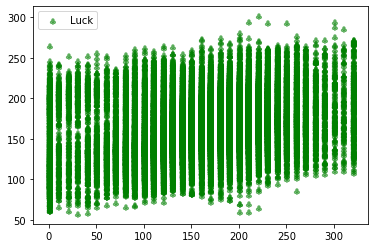

In [58]:
# 3088
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


x = prediction_set_aggregated_df['eonr_12']
y = prediction_set_aggregated_df['eonr_pred']

plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")
plt.legend(loc='upper left')
plt.show()